# Predicting gene knockout strategies

In [2]:
from cameo import load_model, phenotypic_phase_plane

In [3]:
model = load_model('data/e_coli_core.xml.gz')

In [4]:
model.reactions.EX_o2_e.lower_bound = 0

In [5]:
model.reactions.EX_succ_e

Id,EX_succ_e
Name,Succinate exchange
Stoichiometry,succ_e -->
GPR,
Lower bound,0.000000
Upper bound,1000.000000


In [6]:
ppp = phenotypic_phase_plane(model,
                             variables=[model.reactions.BIOMASS_Ecoli_core_w_GAM],
                             objective=model.reactions.EX_succ_e)

ppp.plot()

In [7]:
mutant1 = model.copy()

In [8]:
mutant1.reactions.ACKr.knock_out()
mutant1.reactions.ATPS4r.knock_out()
mutant1.reactions.ATPM.knock_out()
mutant1.reactions.FUM.knock_out()

In [9]:
ppp = phenotypic_phase_plane(mutant1,
                             variables=[mutant1.reactions.BIOMASS_Ecoli_core_w_GAM],
                             objective=mutant1.reactions.EX_succ_e)

ppp.plot()

In [10]:
mutant2 = model.copy()

In [11]:
mutant2.reactions.ACALD.knock_out()
mutant2.reactions.PYK.knock_out()
mutant2.reactions.ME2.knock_out()

In [12]:
ppp = phenotypic_phase_plane(mutant2,
                             variables=[mutant2.reactions.BIOMASS_Ecoli_core_w_GAM],
                             objective=mutant2.reactions.EX_succ_e)

ppp.plot()

In [13]:
mutant3 = model.copy()

In [14]:
mutant3.reactions.ACALD.knock_out()
mutant3.reactions.LDH_D.knock_out()

In [15]:
ppp = phenotypic_phase_plane(mutant3,
                             variables=[mutant3.reactions.BIOMASS_Ecoli_core_w_GAM],
                             objective=mutant3.reactions.EX_succ_e)

ppp.plot()

## Excercises

* Do any of these desigs work under aerobic conditions?
* Can any of these designs actually be achieved with gene knockouts?

## Solutions

### Solution 1

In [17]:
mutant1.reactions.EX_o2_e.lower_bound = -20
ppp = phenotypic_phase_plane(mutant1,
                             variables=[mutant1.reactions.BIOMASS_Ecoli_core_w_GAM],
                             objective=mutant1.reactions.EX_succ_e)

ppp.plot()

In [18]:
mutant2.reactions.EX_o2_e.lower_bound = -20
ppp = phenotypic_phase_plane(mutant2,
                             variables=[mutant2.reactions.BIOMASS_Ecoli_core_w_GAM],
                             objective=mutant2.reactions.EX_succ_e)

ppp.plot()

In [19]:
mutant3.reactions.EX_o2_e.lower_bound = -20
ppp = phenotypic_phase_plane(mutant3,
                             variables=[mutant3.reactions.BIOMASS_Ecoli_core_w_GAM],
                             objective=mutant3.reactions.EX_succ_e)

ppp.plot()

The anwer is no!

### Solution 2

In [43]:
mutant3.reactions.ACALD.gene_name_reaction_rule

'mhpF or adhE'

In [21]:
mutant3.reactions.LDH_D.gene_name_reaction_rule

'dld or ldhA'

In [22]:
for gene in mutant3.reactions.ACALD.genes:
    print(gene.name, gene.reactions)

mhpF frozenset({<Reaction ACALD at 0x11632f0f0>})
adhE frozenset({<Reaction ALCD2x at 0x11632f358>, <Reaction ACALD at 0x11632f0f0>})


In [23]:
for gene in mutant3.reactions.LDH_D.genes:
    print(gene.name, gene.reactions)

ldhA frozenset({<Reaction LDH_D at 0x11632fe48>})
dld frozenset({<Reaction LDH_D at 0x11632fe48>})


In [24]:
mutant4 = model.copy()
mutant4.reactions.ACALD.knock_out()
mutant4.reactions.LDH_D.knock_out()
mutant4.reactions.ALCD2x.knock_out()

In [25]:
ppp = phenotypic_phase_plane(mutant4,
                             variables=[mutant4.reactions.BIOMASS_Ecoli_core_w_GAM],
                             objective=mutant4.reactions.EX_succ_e)

ppp.plot()

The answer is yes!

# Predict gene knockout strategies

In cameo we have two ways of predicting gene knockout targets: using evolutionary algorithms (OptGene) or linear programming (OptKnock)

## OptGene

OptGene is an approach to search for gene or reaction knockouts that relies on evolutionary algorithms[1]. The following image from authors summarizes the OptGene workflow.

<img src="http://static-content.springer.com/image/art%3A10.1186%2F1471-2105-6-308/MediaObjects/12859_2005_Article_632_Fig1_HTML.jpg"/>

Every iteration we keep the best 50 individuals so we can generate a library of targets.

In [26]:
from cameo.strain_design.heuristic.evolutionary_based import OptGene

In [62]:
model = load_model('data/e_coli_core.xml.gz')

In [85]:
optgene = OptGene(model)

In [91]:
result = optgene.run(target=model.reactions.EX_succ_e, 
                     biomass=model.reactions.BIOMASS_Ecoli_core_w_GAM,
                     substrate=model.metabolites.glc__D_e,
                     max_evaluations=15000, population_size=200000, max_knockouts=2,
                     plot=False, growth_coupled=True)

Starting optimization at Sun, 04 Sep 2016 16:29:46


Finished after 00:01:13


In [92]:
result

,reactions,genes,size,fva_min,fva_max,target_flux,biomass_flux,yield,fitness
0,"(CO2t, ACALDt, O2t, ATPS4r)","((b3736, s0001), (s0001, b3731), (s0001, b3732...",2.0,3.606442,8.318280,3.818780,0.108022,0.381878,0.041251
1,"(CO2t, ACALDt, O2t, ATPS4r)","((s0001, b1101, b3734), (b2133, s0001, b3734),...",3.0,3.606442,8.318280,3.818780,0.108022,0.381878,0.041251
2,"(CO2t, GLNabc, ACALDt, O2t, ATPS4r)","((s0001, b0810, b3734),)",3.0,3.606442,8.318280,3.818780,0.108022,0.381878,0.041251
3,"(THD2, CO2t, ACALDt, O2t, ATPS4r)","((s0001, b1603, b3734),)",3.0,3.606442,8.289255,3.818780,0.108022,0.381878,0.041251
...,...,...,...,...,...,...,...,...,...
5,"(CO2t, GLNabc, ACALDt, O2t, ATPS4r)","((b3734, s0001, b0008, b0809), (b2579, s0001, ...",4.0,3.606442,8.318280,3.818780,0.108022,0.381878,0.041251
6,"(CO2t, FRUpts2, ACALDt, O2t, ATPS4r, AKGDH)","((b2097, s0001, b0726, b1819, b3734),)",5.0,3.606442,8.318280,3.818780,0.108022,0.381878,0.041251
7,"(G6PDH2r, MDH, PDH, SUCDi)","((b0723, b1852, b1297, b1773, b1478, b3236, b0...",7.0,5.333516,6.509262,6.430017,0.469781,0.643002,0.302070
8,"(G6PDH2r, PDH, SUCDi)","((b0723, b1723, b1852, b1297, b1773, b1478, b0...",7.0,5.333516,6.525128,6.430017,0.469781,0.643002,0.302070


In [93]:
df = result.data_frame.sort_values('fitness')
df[df.fitness > 0.01]

,reactions,genes,size,fva_min,fva_max,target_flux,biomass_flux,yield,fitness
0,"(CO2t, ACALDt, O2t, ATPS4r)","((b3736, s0001), (s0001, b3731), (s0001, b3732...",2.0,3.606442,8.318280,3.818780,0.108022,0.381878,0.041251
1,"(CO2t, ACALDt, O2t, ATPS4r)","((s0001, b1101, b3734), (b2133, s0001, b3734),...",3.0,3.606442,8.318280,3.818780,0.108022,0.381878,0.041251
2,"(CO2t, GLNabc, ACALDt, O2t, ATPS4r)","((s0001, b0810, b3734),)",3.0,3.606442,8.318280,3.818780,0.108022,0.381878,0.041251
3,"(THD2, CO2t, ACALDt, O2t, ATPS4r)","((s0001, b1603, b3734),)",3.0,3.606442,8.289255,3.818780,0.108022,0.381878,0.041251
...,...,...,...,...,...,...,...,...,...
5,"(CO2t, GLNabc, ACALDt, O2t, ATPS4r)","((b3734, s0001, b0008, b0809), (b2579, s0001, ...",4.0,3.606442,8.318280,3.818780,0.108022,0.381878,0.041251
6,"(CO2t, FRUpts2, ACALDt, O2t, ATPS4r, AKGDH)","((b2097, s0001, b0726, b1819, b3734),)",5.0,3.606442,8.318280,3.818780,0.108022,0.381878,0.041251
7,"(G6PDH2r, MDH, PDH, SUCDi)","((b0723, b1852, b1297, b1773, b1478, b3236, b0...",7.0,5.333516,6.509262,6.430017,0.469781,0.643002,0.302070
8,"(G6PDH2r, PDH, SUCDi)","((b0723, b1723, b1852, b1297, b1773, b1478, b0...",7.0,5.333516,6.525128,6.430017,0.469781,0.643002,0.302070


In [94]:
result.plot(8)

In [95]:
result.display_on_map(8, "e_coli_core.Core metabolism")

## OptKnock

OptKnock uses a bi-level mixed integer linear programming approach to identify reaction knockouts[2]:

$$
\begin{matrix}
maximize & \mathit{v_{chemical}} & & (\mathbf{OptKnock}) \\
\mathit{y_j} & & & \\
subject~to & maximize & \mathit{v_{biomass}} & (\mathbf{Primal}) \\
& \mathit{v_j} & & & & \\
\end{matrix}\\
\begin{bmatrix}
subject~to  & \sum_{j=1}^{M}S_{ij}v_{j} = 0,\\ 
& v_{carbon\_uptake} = v_{carbon~target}\\ 
& v_{apt} \ge v_{apt\_main}\\ 
& v_{biomass} \ge v_{target\_biomass}\\ 
& v_{j}^{min} \cdot y_j \le v_j \le v_{j}^{max} \cdot y_j, \forall j \in \boldsymbol{M} \\
\end{bmatrix}\\
\begin{align}
 & y_j = {0, 1}, & & \forall j \in \boldsymbol{M} & \\
 & \sum_{j \in M} (1 - y_j) \le K& & & \\
\end{align}
$$



In [11]:
from cameo.strain_design.deterministic.linear_programming import OptKnock

In [12]:
optknock = OptKnock(model, fraction_of_optimum=0.1)

Running multiple knockouts with OptKnock can take a few hours or days...


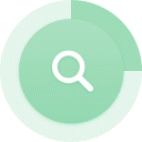

<IPython.core.display.Javascript object>

In [13]:
result = optknock.run(max_knockouts=1, target="EX_ac_e", biomass="BIOMASS_Ecoli_core_w_GAM")

In [14]:
result

/opt/conda/envs/python3.4/lib/python3.4/site-packages/ipywidgets/widgets/widget_string.py:55: UserWarning:

The Latex widget is deprecated. Use Label instead



,reactions,size,EX_ac_e,biomass,fva_min,fva_max
0,{ATPS4r},1.0,14.312267,0.37423,0.0,14.369145


In [15]:
result.plot(0)

In [16]:
result.display_on_map(0, "e_coli_core.Core metabolism")

## References

[1]Patil, K. R., Rocha, I., Förster, J., & Nielsen, J. (2005). Evolutionary programming as a platform for in silico metabolic engineering. BMC Bioinformatics, 6, 308. doi:10.1186/1471-2105-6-308

[2]Burgard, A.P., Pharkya, P., Maranas, C.D. (2003), "OptKnock: A Bilevel Programming Framework for Identifying Gene Knockout Strategies for Microbial Strain Optimization," Biotechnology and Bioengineering, 84(6), 647-657.

## Exercises

* Use OptGene or OptKnock to find a growth coupled design for a product of your choice!